# Project Part I Report

### **1. Imports & Global Variables**

In [1076]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from scipy.linalg import sqrtm, inv
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error, r2_score
from numpy.random import uniform,randn

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

#  Simulation parameter
GPS_Noise = np.diag([0.5, 0.5])**2

Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

### **2. Main Functions**

In [1077]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

In [1078]:
def observation_input(xd, u):
    # add noise to input
    ud = u + Input_Noise @ np.random.randn(2, 1)
    xd = motion_model(xd, ud)
    return xd, ud

In [1079]:
def observation_filters(xTrue,ekf = True,ukf = True,rf_id  = None):
    if ekf:
        # add noise to GPS x-y
        zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
        zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
        z = np.array([[zx, zy]])
    elif ukf:
        # add noise to gps x-yt
        z = observation_model(xTrue) + GPS_Noise @ np.random.randn(2, 1)
    else:
        # add noise to gps x-y
        z = np.zeros((0, 3))

        for i in range(len(rf_id[:, 0])):

            dx = xTrue[0, 0] - rf_id[i, 0]
            dy = xTrue[1, 0] - rf_id[i, 1]
            d = math.hypot(dx, dy)
            if d <= MAX_RANGE:
                dn = d + np.random.randn() * Q_sim[0, 0] ** 0.5  # add noise
                zi = np.array([[dn, rf_id[i, 0], rf_id[i, 1]]])
                z = np.vstack((z, zi))
    return z
    

- #### Observation (GNSS)

In [1080]:
def observation_model(x):
    #  Observation Model
    H = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]])

    z = H @ (x)

    return z

- #### Dynamic Robot model

In [1081]:
def motion_model(x, u):

    F = np.array([[1.0, 0, 0, 0],
                  [0, 1.0, 0, 0],
                  [0, 0, 1.0, 0],
                  [0, 0, 0, 0]])

    B = np.array([[dt * math.cos(x[2, 0]), 0],
                  [dt * math.sin(x[2, 0]), 0],
                  [0.0, dt],
                  [1.0, 0.0]])

    x = F.dot(x) + B.dot(u)
    return x

### **3. Filters Algorithms**

#### A. Dead-Reckoning
Process of calculating current position of some moving object by using a previously determined position, or fix, and then incorporating estimates of speed, heading direction, and course over elapsed time.

#### B. Extended Kalman Filter (EKF)

In the real world, we have non linear equations because we may be predicting in one direction while our sensor is taking reading in some other direction, so it involves angles and sin and cos functions which are non linear. So EKF takes helps of Taylor Series (and Jacobian Matrix further) to linearly approximate a non linear function around the mean of the Gaussian and then predict the values.

1st order Taylor polynomial is the <u>linear approximation</u> of the function.

2nd order Taylor polynomial is often referred to as the <u> quadratic approximation</u>.

**Parameters**

In [1082]:
# Estimation parameters of EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
R = np.diag([1.0, 1.0])**2  # Observation x,y position covariance

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

**Jacobian Matrix Calculation**

In [1083]:
def jacobH(x):
    # Jacobian of Observation Model
    jH = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]])

    return jH

In [1084]:
def jacobF(x, u):
    yaw = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -dt * v * math.sin(yaw), dt * math.cos(yaw)],
        [0.0, 1.0, dt * v * math.cos(yaw), dt * math.sin(yaw)],
        [0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 1.0]])

    return jF

**EKF Algorithm**
- Notes:
    - PEst is the covariance matrix of the state at time t;
    - Q is the covariance matrix of the system noise;
    - R is the covariance matrix of the observation noise.


In [1085]:
def ekf_estimation(xEst, PEst, z, u):

    #  Predict
    xPred = motion_model(xEst, u)
    jF = jacobF(xPred, u)
    PPred = jF.dot(PEst).dot(jF.T) + Q

    #  Update
    jH = jacobH(xPred)
    zPred = observation_model(xPred)
    y = z.T - zPred
    S = jH.dot(PPred).dot(jH.T) + R
    K = PPred.dot(jH.T).dot(np.linalg.inv(S))
    xEst = xPred + K.dot(y)
    PEst = (np.eye(len(xEst)) - K.dot(jH)).dot(PPred)

    return xEst, PEst

#### C. Undescented Kalman Filter (UKF)

Both in the EKF and in the LKF, non-linear functions are locally approximated with linear equations obtained from Taylor expansion. In a highly non-linear systems such solution can introduce significant errors because the linearization uses only the first term of a Taylor series. In such cases, it may be beneficial to use the UKF algorithm that, as an alternative to linearizing non-linear equations, uses non-linear transformations on a set of deterministically chosen sigma points.

The main difference from EKF is that in EKF we take only one point i.e. mean and approximate, but in UKF we take a bunch of points called sigma points and approximate with a fact that more the number of points, more precise our approximation will be!

**Parameters**

In [1086]:
# Covariance for UKF simulation
Q = np.diag([
    0.1,  # variance of location on x-axis
    0.1,  # variance of location on y-axis
    np.deg2rad(1.0),  # variance of yaw angle
    1.0  # variance of velocity
]) ** 2  # predict state covariance
R = np.diag([1.0, 1.0]) ** 2  # Observation x,y position covariance

#  Simulation parameter
GPS_Noise = np.diag([0.5, 0.5])**2
Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

#  UKF Parameter
ALPHA = 0.001
BETA = 2
KAPPA = 0

**Weights & Gamma Calculations**

In [1087]:
def setup_ukf(xDim):
    # calculate lambda
    lamb = ALPHA ** 2 * (xDim + KAPPA) - xDim
    # calculate the weights
    # w^(0)
    wm = [lamb / (lamb + xDim)] # wm corresponds to w of the UKF Algorithm
    # wc^(0)
    wc = [(lamb / (lamb + xDim)) + (1 - ALPHA ** 2 + BETA)]
    for i in range(2 * xDim):
        # w^(+-i)
        wm.append(1.0 / (2 * (xDim + lamb)))
        # wc^(+-i)
        wc.append(1.0 / (2 * (xDim + lamb)))
    
    # define gamma
    gamma = math.sqrt(xDim + lamb)

    wm = np.array([wm])
    wc = np.array([wc])

    return wm, wc, gamma

**UKF Algorithm**
- Sigma Points 

In [1088]:
def generate_sigma_points(xEst, PEst, gamma):
    # Calculate the sigma points using xEst (xhat_k|k), PEst (P_k|k) and gamma
    # or using xPred (xhat_k|k-1), PPred (P_k|k-1) and gamma
    x_0 = xEst

    sigma_neg = xEst - gamma * sqrtm(PEst)
    sigma_pos = xEst + gamma * sqrtm(PEst)

    return np.concatenate((x_0, sigma_neg, sigma_pos), axis=1)

In [1089]:
def predict_sigma_motion(sigma, u):
    # Sigma Points prediction with motion model
    return motion_model(sigma, u)

In [1090]:
def predict_sigma_observation(sigma):
    # Sigma Points prediction with observation model
    return observation_model(sigma)

- Covarience of sigma Formula

In [1091]:
def calc_sigma_covariance(x, sigma, wc, Pi):
    # Calculate the covariance P = PPred (P_k|k-1) using x = xPred (xhat_k+1|k),
    # sigma (x^(i)_k+1|k), wc and Pi = Q (initial value of PPred)
    # or calculate the covariance P = st (P^yy_t|t-1) using x = zb (yhat_t),
    # sigma = z_sigma (y^(i)_t), wc and Pi = R (initial value of st)
    
    return wc * (sigma-x) @ (sigma-x).T + Pi 

- Updated mean and covariance:

In [1092]:
def calc_pxz(sigma, x, z_sigma, zb, wc):
    # Calculate the covariance Pxz (P^xy_t|t-1) using wc, sigma (x^(i)_t|t-1),
    # x (xhat_t|t-1), z_sigma (y^(i)_t) and zb (yhat_t) and 
    return wc * (sigma-x) @ (z_sigma-zb).T

In [1093]:
def ukf_estimation(xEst, PEst, z, u, wm, wc, gamma):
    #  Predict (UKF - time update)
    
    # Calculate the sigma-points 
    # Using: xExt == xhat_k|k and PEst == P_k|k and gamma 
    sigma = generate_sigma_points(xEst, PEst, gamma)

    # Propagate the sigma-points 
    # sigma_propagated = (x^(i)_k+1|k = f(x^(i)_k|k , w^(i)_k)) 
    # using the sigma-points obtained in the previous calculus and u (ud = noisy u)
    sigma_propagated = predict_sigma_motion(sigma, u)

    # xPred == xhat_k+1|k 
    # Using: wm and sigma_propagated
    xPred = wm @ sigma_propagated.T  
    xPred = xPred.T

    # Calculate PPred (P_k|k-1) using xPred, the propagated sigma-points
    # wc and Q in def calc_sigma_covariance
    PPred = calc_sigma_covariance(xPred, sigma_propagated, wc, Q)

    #  Update (UKF - measurement update)
    
    # Calculate zPred (yhat_t) using xPred (xhat_k+1|k) in def observation_model
    zPred = observation_model(xPred)

    # Calculate y = (y_t - yhat_t) using z (y_t) and zPred (yhat_t)
    y = z - zPred

    # Calculate the sigma-points using xPred (xhat_k|k-1), PPred (P_k|k-1)
    # and gamma in def generate_sigma_points
    sigma = generate_sigma_points(xPred, PPred, gamma)

    # Propagate the sigma-points z_sigma (y^(i)_t = h(x^(i)_t|t-1 , e^(i)_t)) 
    # using the propagated sigma-points in def predict_sigma_observation
    z_sigma = predict_sigma_observation(sigma)

    # Calculate zb (yhat_t) using wm and the sigma-points y^(i)_t 
    zb = wm @ z_sigma.T
    zb = zb.T 

    # Calculate the sigma covariance, st (P^yy_t|t-1), using zb (yhat_t),
    # z_sigma (y^(i)_t), wc and R in def calc_sigma_covariance
    st = calc_sigma_covariance(zb, z_sigma, wc, R.T)
    
    # Pxz == (P^xy_t|t-1) 
    # Using sigma (x^(i)_t|t-1), xPred (xhat_t|t-1),
    # z_sigma (y^(i)_t), zb (yhat_t) and wc in def calc_pxz
    Pxz = calc_pxz(sigma, xPred, z_sigma, zb, wc)    
    
    # K_t == Pxz (P^xy_t|t-1)
    K_t = Pxz @ inv(st.astype(float))
    
    # Update xEst (Xhat_t|t) using xPred (xhat_t|t-1), K_t and y (y_t - yhat_t)
    xEst = xPred + K_t @ y
    
    # Update PEst (P_t|t) using PPred (P_t|t-1), K_t and st (P^yy_t|t-1)
    PEst = PPred - K_t @ st @ K_t.T
    
    return xEst, PEst

#### D. Particle Filter 

This filter uses relatively few particles compared with the standard particle filter and captures the non-Gaussian features of the true signal, which are typical in complex nonlinear systems.

Unlike the previously presented algorithms that determine the robot's motion through predictions and comparisons with real data, this algorithm generates several points and applies the same motion until it reaches the robot's actual position. A more detailed description of the algorithm follows:

1. We start by creating some reference points to make comparisons

2. Next, several particles are generated at random positions in the search space. All particles have the same probability of being in the right place.

3. The real position (obtained from GPS data for example) is then compared with all the generated particles (through the distances to our reference points) and the particles that are in similar positions will thus have a higher weight.

4. In the positions where we conclude that it is more likely to match reality, we generate new particles in those regions.

5. The robot moves and we apply the same motion to the particles.

6. From here we repeat steps 3, 4 and 5.

7. Over time, the particles tend to move closer to reality.

The code of this filter was developed from this source: https://github.com/AtsushiSakai/PythonRobotics/blob/master/Localization/particle_filter/particle_filter.py


**Parameters**

In [1094]:
# Estimation parameter of PF
Q_pf = np.diag([0.2]) ** 2  # range error
R_pf = np.diag([2.0, np.deg2rad(40.0)]) ** 2  # input error

#  Simulation parameter
Q_sim = np.diag([0.2]) ** 2
R_sim = np.diag([1.0, np.deg2rad(30.0)]) ** 2
MAX_RANGE = 20.0  # maximum observation range

# Particle filter parameter
NP = 100  # Number of Particle
NTh = NP / 2.0  # Number of particle for re-sampling


In [1095]:
def gauss_likelihood(x, sigma):
    p = 1.0 / math.sqrt(2.0 * math.pi * sigma ** 2) * \
        math.exp(-x ** 2 / (2 * sigma ** 2))

    return p

def calc_covariance(x_est, px, pw):
    """
    calculate covariance matrix
    see ipynb doc
    """
    cov = np.zeros((3, 3))
    n_particle = px.shape[1]
    for i in range(n_particle):
        dx = (px[:, i:i + 1] - x_est)[0:3]
        cov += pw[0, i] * dx @ dx.T
    cov *= 1.0 / (1.0 - pw @ pw.T)

    return cov

def pf_localization(px, pw, z, u):
    """
    Localization with Particle filter
    """

    for ip in range(NP):
        x = np.array([px[:, ip]]).T
        w = pw[0, ip]

        #  Predict with random input sampling
        ud1 = u[0, 0] + np.random.randn() * R_pf[0, 0] ** 0.5
        ud2 = u[1, 0] + np.random.randn() * R[1, 1] ** 0.5
        ud = np.array([[ud1, ud2]]).T
        x = motion_model(x, ud)

        #  Calc Importance Weight
        for i in range(len(z[:, 0])):
            dx = x[0, 0] - z[i, 1]
            dy = x[1, 0] - z[i, 2]
            pre_z = math.hypot(dx, dy)
            dz = pre_z - z[i, 0]
            w = w * gauss_likelihood(dz, math.sqrt(Q_pf[0, 0]))

        px[:, ip] = x[:, 0]
        pw[0, ip] = w

    pw = pw / pw.sum()  # normalize

    x_est = px.dot(pw.T)
    p_est = calc_covariance(x_est, px, pw)

    N_eff = 1.0 / (pw.dot(pw.T))[0, 0]  # Effective particle number
    if N_eff < NTh:
        px, pw = re_sampling(px, pw)
    return x_est, p_est, px, pw
def re_sampling(px, pw):
    """
    low variance re-sampling
    """

    w_cum = np.cumsum(pw)
    base = np.arange(0.0, 1.0, 1 / NP)
    re_sample_id = base + np.random.uniform(0, 1 / NP)
    indexes = []
    ind = 0
    for ip in range(NP):
        while re_sample_id[ip] > w_cum[ind]:
            ind += 1
        indexes.append(ind)

    px = px[:, indexes]
    pw = np.zeros((1, NP)) + 1.0 / NP  # init weight

    return px, pw

### **4.Simulation**

#### A. Functions to measure performance of the algorithms

**R2_Score** is the proportion of the variance in the dependent variable that is predictable from the independent variable(s)

In [1096]:
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)
    
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def get_metrics(xTrue,xPred):
    return np.array([mse(xTrue,xPred),rmse(xTrue,xPred),r2(xTrue,xPred)])
    

#### B. Simulation

In [1097]:
ekf = True
ukf = True
pf = True

In [1098]:
def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0
    
    try:
        a = math.sqrt(eigval[bigind])
    except ValueError:
        a = 0

    try:
        b = math.sqrt(eigval[smallind])
    except ValueError:
        b = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [1099]:
def simulation(show = True):
    
    xDim = 4  # State Vector [x y yaw v]'

    # xTrue: x_k|k-1 (given by the motion_model using x and u)
    # xDR: xDR_k|k-1 (given by the motion_model using xDR_k-1 and noisy u)
    xTrue = np.zeros((xDim, 1))
    xDR = np.zeros((xDim, 1))  # Dead reckoning    

    xEst_ukf = np.zeros((xDim, 1))
    xEst_ekf = np.zeros((xDim, 1))
    xEst_pf = np.zeros((xDim, 1))

    PEst_ekf = np.eye(xDim)
    PEst_ukf = np.eye(xDim)
    
    if ukf is True:
        wm, wc, gamma = setup_ukf(xDim)

    # history
    hxTrue = xTrue
    hxDR = xTrue
    hxEst_ekf = xEst_ekf
    hxEst_ukf = xEst_ukf
    hxEst_pf = xEst_pf
    
    hz = np.zeros((1,2))
    hz_pf = np.zeros ((0, 3))

    # RF_ID positions [x, y]
    rf_id = np.array([[10.0, 0.0],
                      [10.0, 10.0],
                      [0.0, 15.0],
                      [-5.0, 20.0]])

    # create particles and weights
    px = np.zeros((4, NP))  # Particle store
    pw = np.zeros((1, NP)) + 1.0 / NP  # Particle weight
    
    time = 0.0


    while SIM_TIME >= time:
        time += dt
        # effective values of the input variables (v and omega)
        u = calc_input()
        
        # z: noisy GPS output variables (given by observation_model)
        # ud: noisy u
        xTrue = motion_model(xTrue, u)
        xDR,ud = observation_input(xDR, u)
        if ekf is True:
            z = observation_filters(xTrue)
            xEst_ekf, PEst_ekf = ekf_estimation(xEst_ekf, PEst_ekf, z, ud)
            hxEst_ekf = np.hstack((hxEst_ekf, xEst_ekf))
            hz = np.vstack((hz, z))
        if ukf is True:
            z = observation_filters(xTrue,ekf = False)
            # Estimation of xEst, PEst using the UKF algorithm 
            xEst_ukf, PEst_ukf = ukf_estimation(xEst_ukf, PEst_ukf, z, ud, wm, wc, gamma)
            hxEst_ukf = np.hstack((hxEst_ukf, xEst_ukf))
        if pf is True:
            z = observation_filters(xTrue,ekf=False,ukf=False,rf_id=rf_id)
            xEst_pf, PEst_pf, px, pw = pf_localization(px, pw, z, ud)
            hxEst_pf = np.hstack((hxEst_pf, xEst_pf))
            hz_pf = np.vstack((hz_pf,z))
        
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
    
    if show is True:
        fig, axs = plt.subplots(1,2)
        fig.show()
        fig.set_size_inches(23, 10.5)
        plt.cla()
        plt.gcf().canvas.mpl_connect('key_release_event',lambda event: [exit(0) if event.key == 'escape' else None])
        axs[0].title.set_text('EKF & UKF')
        axs[0].plot(hz[:, 0], hz[:, 1], ".g",label="GPS Signal")
        axs[0].plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b",label="True Position")
        axs[0].plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k",label="Dead-Reckoning")
        axs[0].grid()


        if ekf is True:
            axs[0].plot(hxEst_ekf[0, :].flatten(), hxEst_ekf[1, :].flatten(), "-r", label="EKF")
        if ukf is True:
            axs[0].plot(hxEst_ukf[0, :].flatten(), hxEst_ukf[1, :].flatten(), "-m", label="UKF")
        axs[0].legend()
        
        if pf is True:
            axs[1].title.set_text('Particle Filter')
            for i in range(len(hz_pf[:, 0])):
                axs[1].plot([xTrue[0, 0], hz_pf[i, 1]], [xTrue[1, 0], hz_pf[i, 2]], "-k")
            axs[1].grid()
            axs[1].plot(hxEst_pf[0, :].flatten(), hxEst_pf[1, :].flatten(), "-r", label="Particle Filter")
            axs[1].plot(rf_id[:, 0], rf_id[:, 1], "*k", label = "Landmarks")
            axs[1].plot(px[0, :], px[1, :], ".r")
            axs[1].plot(np.array(hxTrue[0, :]).flatten(),
            np.array(hxTrue[1, :]).flatten(), "-b", label = "trajetória verdadeira")
            axs[1].plot(np.array(hxDR[0, :]).flatten(),np.array(hxDR[1, :]).flatten(), "-k", label = "trajetória por posicionamento relativo")
            axs[1].legend()
        fig.canvas.draw()
        
    if ekf is True:
        metricsEKF = get_metrics(hxTrue.T[:, :2], hxEst_ekf.T[:, :2])
    else:
        metricsEKF = None
    
    if ukf is True:
        metricsUKF = get_metrics(hxTrue.T[:, :2],hxEst_ukf.T[:, :2])
    else:
        metricsUKF = None

    if pf is True:
        metricsPF = get_metrics(hxTrue.T[:, :2],hxEst_pf.T[:, :2])
    else:
        metricsPF = None

    metricsDR = get_metrics(hxTrue.T[:, :2],hxDR.T[:, :2])
    return metricsDR,metricsEKF,metricsUKF,metricsPF

<ipython-input-1099-00db930cf0f6>:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(array([4.48205256e+01, 6.55678872e+00, 1.80663993e-02]),
 array([0.02769162, 0.1657685 , 0.99940269]),
 array([0.30840555, 0.5531645 , 0.99351313]),
 array([0.01345302, 0.11598484, 0.99971367]))

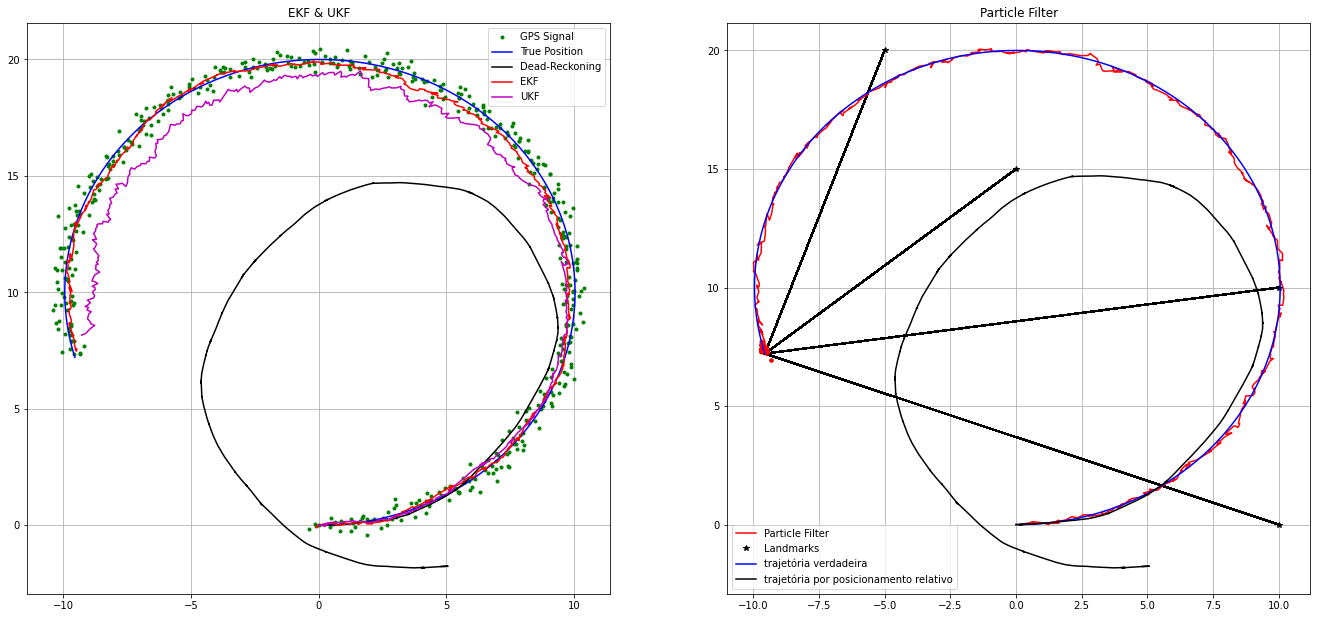

In [1100]:
#One simulation
simulation()

- #### Filter comparison with the reality

In [1101]:
#Always a multiple of 5
numSimulations = 50

#First column = mean square error
#Second column = real mean square error
#Third column = r2
metrics_DR_sims = np.zeros((numSimulations,3))
metrics_EKF_sims = np.zeros((numSimulations,3))
metrics_UKF_sims = np.zeros((numSimulations,3))
metrics_PF_sims = np.zeros((numSimulations,3))


for i in range(numSimulations):
    # True position, dead-reckoning, ekf, ukf, particle filter
    metrics_DR,metrics_EKF,metrics_UKF,metrics_PF = simulation(False)
    metrics_DR_sims[i] = metrics_DR
    if ekf is True:
        metrics_EKF_sims[i] = metrics_EKF
    if ukf is True:
        metrics_UKF_sims[i] = metrics_UKF
    if pf is True:
        metrics_PF_sims[i] = metrics_PF

metrics_DR = []
metrics_UKF = []
metrics_EKF = []
metrics_PF = []

for i in range(3):
    metrics_DR.append(np.average(metrics_DR_sims[:,i])),
    metrics_DR.append(np.std(metrics_DR_sims[:,i]))
    if ekf is True:
        metrics_EKF.append(np.average(metrics_EKF_sims[:,i])),
        metrics_EKF.append(np.std(metrics_EKF_sims[:,i]))
    if ukf is True:
        metrics_UKF.append(np.average(metrics_UKF_sims[:,i])),
        metrics_UKF.append(np.std(metrics_UKF_sims[:,i]))
    if pf is True:
        metrics_PF.append(np.average(metrics_PF_sims[:,i])),
        metrics_PF.append(np.std(metrics_PF_sims[:,i]))
indexNames = ["Dead-Reckoning"]
finalData = [metrics_DR]

if ekf is True:
    indexNames.append("EKF")
    finalData.append(metrics_EKF)
if ukf is True:
    indexNames.append("UKF")
    finalData.append(metrics_UKF)
if pf is True:
    indexNames.append("Particle Filter")
    finalData.append(metrics_PF)


df_metrics = pd.DataFrame( data = finalData,
    
    columns=[
        "MSE_mean",
        "MSE_std",
        "RMSE_mean",
        "RMSE_std",
        "R^2_mean",
        "R^2_std"
    ],
    index= indexNames)

## **5. Conclusions**

In [1102]:
df_metrics

,MSE_mean,MSE_std,RMSE_mean,RMSE_std,R^2_mean,R^2_std
Dead-Reckoning,23.134272,26.398845,4.097011,2.227274,0.506546,0.555844
EKF,0.020616,0.005436,0.142118,0.017734,0.999562,0.000115
UKF,0.117273,0.105484,0.314637,0.130972,0.997507,0.002248
Particle Filter,0.013552,0.001575,0.116154,0.006592,0.999711,0.000034


**Criteria:**
- Regarding the MSE and RMSE values, the closer the values are to zero, the closer the model is to reality.
- To obtain the MSE and RMSE values, each algorithm was tested 50 times, thus obtaining 30 values for each algorithm and metric. The final result is the mean and standard deviation of these same values.

**Analysis:**
- The Dead-Recoking algorithm is the worst performing as we can see from the metrics
- EKF and UKF have very close results though EKF shows a slightly better perfomance than UKF which wasn't expected since the UKF algorithm due to the usage of sigma points should have a better aproximation
- EKF, UKF and Particle Filter are very stable algorithms since they have a low MSE_std values, being the most stable the Partcile Filter
- EKF, UKF and Particle Filter show results pretty close to reality, we can see that by the R2_Score mean

## **6. References**

https://towardsdatascience.com/the-unscented-kalman-filter-anything-ekf-can-do-i-can-do-it-better-ce7c773cf88d

https://www.pnas.org/doi/10.1073/pnas.1617398113

https://www.spiedigitallibrary.org/conference-proceedings-of-spie/11442/114421C/Unscented-Kalman-filter-application-in-personal-navigation/10.1117/12.2564984.full?SSO=1